In [3]:
# -*- coding: utf-8 -*-
"""
Pipeline complet et final de traitement et d'analyse des données d'abonnements.
Version définitive avec imputation de données avancée pour les dates manquantes.
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

# --- CONFIGURATION ---
TRANSACTIONS_FILE = 'transaction.csv'
COUPONS_FILE = 'Table des coupons-1.xlsx - Coupons.csv'
OUTPUT_FILE = 'rapport_mensuel_detaille.csv'

# --- Définition des fonctions ---

def load_and_merge_data(transactions_path, coupons_path):
    """Charge, fusionne, nettoie et enrichit les données initiales."""
    print("--- Étape 1: Chargement, fusion et enrichissement ---")
    try:
        df_trans = pd.read_csv(transactions_path, encoding='latin1')
        df_coupons = pd.read_csv(coupons_path, encoding='latin1')
        df_merged = pd.merge(df_trans, df_coupons, left_on='discount', right_on='Coupon Id', how='left')
        df_cleaned = df_merged.drop_duplicates().reset_index(drop=True)
        
        df_cleaned['nom_offre'] = np.where(pd.notna(df_cleaned['tm_campaign']), df_cleaned['tm_campaign'], df_cleaned['discount'])
        df_cleaned['nom_offre'] = df_cleaned['nom_offre'].fillna('Offre Standard')
        return df_cleaned
    except Exception as e:
        print(f"ERREUR CRITIQUE lors du chargement : {e}")
        return None

def group_and_impute_data(df):
    """Agrège les données et impute les dates d'échéance manquantes de manière robuste."""
    if df is None: return None
    print("\n--- Étape 2: Agrégation et imputation avancée des dates ---")
    
    # On convertit les dates d'abord, en ignorant les erreurs pour le moment
    df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
    df['ECHEANCE_date'] = pd.to_datetime(df['ECHEANCE_date'], errors='coerce')
    
    # 1. Agrégation robuste avec min/max pour ignorer les dates invalides (NaT)
    agg_logic = {
        'order_date': 'min',
        'ECHEANCE_date': 'max',
    }
    # Pour les autres colonnes, on prend la première valeur non-nulle
    for col in df.columns:
        if col not in agg_logic and col != 'subscription_id':
            agg_logic[col] = 'first'

    df_grouped = df.groupby('subscription_id').agg(agg_logic).reset_index()
    print(f"-> Agrégation robuste terminée.")

    # 2. Imputation intelligente pour les dates encore manquantes
    # Cas 1: La date de fin est manquante mais la date de début est valide
    condition_fix_echeance = (
        df_grouped['frequence'].str.lower().str.contains('monthly', na=False) &
        pd.isna(df_grouped['ECHEANCE_date']) &
        pd.notna(df_grouped['order_date'])
    )
    df_grouped.loc[condition_fix_echeance, 'ECHEANCE_date'] = df_grouped.loc[condition_fix_echeance, 'order_date'] + pd.Timedelta(days=30)
    print(f"-> {condition_fix_echeance.sum()} dates de fin manquantes ont été 'forgées'.")

    # Cas 2: La date de début est manquante mais la date de fin est valide
    condition_fix_order = (
        df_grouped['frequence'].str.lower().str.contains('monthly', na=False) &
        pd.isna(df_grouped['order_date']) &
        pd.notna(df_grouped['ECHEANCE_date'])
    )
    df_grouped.loc[condition_fix_order, 'order_date'] = df_grouped.loc[condition_fix_order, 'ECHEANCE_date'] - pd.Timedelta(days=30)
    print(f"-> {condition_fix_order.sum()} dates de début manquantes ont été 'forgées'.")

    # On supprime les abonnements qui restent inutilisables (les deux dates sont manquantes)
    initial_rows = len(df_grouped)
    df_grouped.dropna(subset=['order_date', 'ECHEANCE_date'], inplace=True)
    print(f"-> {initial_rows - len(df_grouped)} abonnements inutilisables (sans aucune date) ont été supprimés.")

    return df_grouped

# Le reste du script reste identique car il prend en entrée des données maintenant nettoyées
def create_monthly_report(df_sub):
    """Transforme les abonnements en un rapport mensuel détaillé."""
    if df_sub is None: return None
    print("\n--- Étape 3: Création des parcours et expansion mensuelle ---")
    
    df_sorted = df_sub.sort_values(by=['customer_id', 'order_date']).copy()
    
    df_sorted['echeance_precedente'] = df_sorted.groupby('customer_id')['ECHEANCE_date'].shift(1)
    df_sorted['duree_trou_jours'] = (df_sorted['order_date'] - df_sorted['echeance_precedente']).dt.days
    
    seuil_churn_jours = np.where(df_sorted['frequence'].str.lower().str.contains('monthly', na=False), 35, 90)
    df_sorted['nouveau_parcours'] = np.where((df_sorted['duree_trou_jours'].isna()) | (df_sorted['duree_trou_jours'] >= seuil_churn_jours), True, False)
    
    df_sorted['id_parcours'] = df_sorted['customer_id'].astype(str) + '_' + df_sorted['nouveau_parcours'].cumsum().astype(str)
    df_sorted['journey_start_date'] = df_sorted.groupby('id_parcours')['order_date'].transform('min')
    
    all_months_data = []
    for row in df_sorted.itertuples(index=False):
        start_month = row.order_date.to_period('M').to_timestamp()
        end_month = row.ECHEANCE_date.to_period('M').to_timestamp()
        date_range = pd.date_range(start=start_month, end=end_month, freq='MS')

        for month_date in date_range:
            month_relatif = (month_date.year - row.journey_start_date.year) * 12 + (month_date.month - row.journey_start_date.month)
            montant_mensuel = 0
            try:
                revenue = float(str(getattr(row, 'consolidated_revenues_ht_euro', '0')).replace(',', '.'))
                frequence = str(getattr(row, 'frequence', '')).lower()
                if 'annual' in frequence: montant_mensuel = revenue / 12
                elif 'monthly' in frequence: montant_mensuel = revenue
            except (ValueError, TypeError): pass
            
            new_row = {col: getattr(row, col) for col in row._fields}
            new_row.update({'month': month_date, 'month_relatif': month_relatif, 'Montant': montant_mensuel})
            all_months_data.append(new_row)
            
    return pd.DataFrame(all_months_data)

def analyze_churn_characteristics(df):
    """Identifie les clients churnés tôt et analyse leurs caractéristiques."""
    if df is None or df.empty: return
    print("\n--- Étape 4: Analyse des caractéristiques du Churn ---")
    
    df['duree_parcours'] = df.groupby('id_parcours')['month_relatif'].transform('max')
    
    df_churners = df[df['duree_parcours'] <= 2].copy()
    df_retained = df[df['duree_parcours'] > 2].copy()
    
    print(f"-> {df_churners['customer_id'].nunique()} clients ont churné dans les 3 premiers mois.")
    print(f"-> {df_retained['customer_id'].nunique()} clients sont restés au-delà de 3 mois.")

    churners_initial = df_churners[df_churners['month_relatif'] == 0].drop_duplicates(subset=['id_parcours'])
    retained_initial = df_retained[df_retained['month_relatif'] == 0].drop_duplicates(subset=['id_parcours'])

    caracteristiques_a_analyser = ['nom_offre', 'frequence', 'payment_origin', 'psp', 'tm_source']
    
    for char in caracteristiques_a_analyser:
        print(f"\n--- Comparaison pour : {char} ---")
        churn_dist = churners_initial[char].value_counts(normalize=True).mul(100).rename('Churners (%)')
        retained_dist = retained_initial[char].value_counts(normalize=True).mul(100).rename('Retenus (%)')
        
        df_dist = pd.concat([churn_dist, retained_dist], axis=1).fillna(0).sort_values(by='Churners (%)', ascending=False)
        print(df_dist.head(10).round(2))

def main():
    """Fonction principale qui orchestre l'ensemble du pipeline."""
    df_initial = load_and_merge_data(TRANSACTIONS_FILE, COUPONS_FILE)
    df_aggregated = group_and_impute_data(df_initial)
    df_monthly_report = create_monthly_report(df_aggregated)
    
    if df_monthly_report is not None:
        analyze_churn_characteristics(df_monthly_report)
        print(f"\n--- Sauvegarde du rapport final ---")
        try:
            df_monthly_report.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')
            print(f"-> Pipeline terminé. Fichier de sortie : '{OUTPUT_FILE}'")
        except Exception as e:
            print(f"ERREUR CRITIQUE lors de la sauvegarde : {e}")

if __name__ == "__main__":
    main()

--- Étape 1: Chargement, fusion et enrichissement ---

--- Étape 2: Agrégation et imputation avancée des dates ---


/var/folders/sq/50hbq0292x93_z2jh1gmtt8m0000gn/T/ipykernel_39334/947028902.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
/var/folders/sq/50hbq0292x93_z2jh1gmtt8m0000gn/T/ipykernel_39334/947028902.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ECHEANCE_date'] = pd.to_datetime(df['ECHEANCE_date'], errors='coerce')


-> Agrégation robuste terminée.
-> 1565 dates de fin manquantes ont été 'forgées'.
-> 1835 dates de début manquantes ont été 'forgées'.
-> 31404 abonnements inutilisables (sans aucune date) ont été supprimés.

--- Étape 3: Création des parcours et expansion mensuelle ---

--- Étape 4: Analyse des caractéristiques du Churn ---
-> 12578 clients ont churné dans les 3 premiers mois.
-> 10295 clients sont restés au-delà de 3 mois.

--- Comparaison pour : nom_offre ---
                                                    Churners (%)  Retenus (%)
nom_offre                                                                    
Offre Standard                                             26.57        25.01
promo_generique_abonnement_nav_octobre_2017                16.04        11.86
bouton_footer_article_abonnez_vous                          9.74         8.03
jad_offre_winback_echus_mensuel_0_09_2024                   2.42         0.03
country_medium_rfv_defaut_offre_1euro_avril_2024            2.17

In [4]:
# -*- coding: utf-8 -*-
"""
Pipeline complet et final de traitement et d'analyse des données d'abonnements.
Version définitive avec imputation de données avancée pour les dates manquantes.
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

# --- CONFIGURATION ---
TRANSACTIONS_FILE = 'transaction.csv'
COUPONS_FILE = 'Table des coupons-1.xlsx - Coupons.csv'
OUTPUT_FILE = 'rapport_mensuel_detaille.csv'

# --- Définition des fonctions ---

def load_and_merge_data(transactions_path, coupons_path):
    """Charge, fusionne, nettoie et enrichit les données initiales."""
    print("--- Étape 1: Chargement, fusion et enrichissement ---")
    try:
        df_trans = pd.read_csv(transactions_path, encoding='latin1')
        df_coupons = pd.read_csv(coupons_path, encoding='latin1')
        df_merged = pd.merge(df_trans, df_coupons, left_on='discount', right_on='Coupon Id', how='left')
        df_cleaned = df_merged.drop_duplicates().reset_index(drop=True)
        
        df_cleaned['nom_offre'] = np.where(pd.notna(df_cleaned['tm_campaign']), df_cleaned['tm_campaign'], df_cleaned['discount'])
        df_cleaned['nom_offre'] = df_cleaned['nom_offre'].fillna('Offre Standard')
        return df_cleaned
    except Exception as e:
        print(f"ERREUR CRITIQUE lors du chargement : {e}")
        return None

def group_and_impute_data(df):
    """Agrège les données et impute les dates d'échéance manquantes de manière robuste."""
    if df is None: return None
    print("\n--- Étape 2: Agrégation et imputation avancée des dates ---")
    
    # On convertit les dates d'abord, en ignorant les erreurs pour le moment
    df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
    df['ECHEANCE_date'] = pd.to_datetime(df['ECHEANCE_date'], errors='coerce')
    
    # 1. Agrégation robuste avec min/max pour ignorer les dates invalides (NaT)
    agg_logic = {
        'order_date': 'min',
        'ECHEANCE_date': 'max',
    }
    # Pour les autres colonnes, on prend la première valeur non-nulle
    for col in df.columns:
        if col not in agg_logic and col != 'subscription_id':
            agg_logic[col] = 'first'

    df_grouped = df.groupby('subscription_id').agg(agg_logic).reset_index()
    print(f"-> Agrégation robuste terminée.")

    # 2. Imputation intelligente pour les dates encore manquantes
    # Cas 1: La date de fin est manquante mais la date de début est valide
    condition_fix_echeance = (
        df_grouped['frequence'].str.lower().str.contains('monthly', na=False) &
        pd.isna(df_grouped['ECHEANCE_date']) &
        pd.notna(df_grouped['order_date'])
    )
    df_grouped.loc[condition_fix_echeance, 'ECHEANCE_date'] = df_grouped.loc[condition_fix_echeance, 'order_date'] + pd.Timedelta(days=30)
    print(f"-> {condition_fix_echeance.sum()} dates de fin manquantes ont été 'forgées'.")

    # Cas 2: La date de début est manquante mais la date de fin est valide
    condition_fix_order = (
        df_grouped['frequence'].str.lower().str.contains('monthly', na=False) &
        pd.isna(df_grouped['order_date']) &
        pd.notna(df_grouped['ECHEANCE_date'])
    )
    df_grouped.loc[condition_fix_order, 'order_date'] = df_grouped.loc[condition_fix_order, 'ECHEANCE_date'] - pd.Timedelta(days=30)
    print(f"-> {condition_fix_order.sum()} dates de début manquantes ont été 'forgées'.")

    # On supprime les abonnements qui restent inutilisables (les deux dates sont manquantes)
    initial_rows = len(df_grouped)
    df_grouped.dropna(subset=['order_date', 'ECHEANCE_date'], inplace=True)
    print(f"-> {initial_rows - len(df_grouped)} abonnements inutilisables (sans aucune date) ont été supprimés.")

    return df_grouped

# Le reste du script reste identique car il prend en entrée des données maintenant nettoyées
def create_monthly_report(df_sub):
    """Transforme les abonnements en un rapport mensuel détaillé."""
    if df_sub is None: return None
    print("\n--- Étape 3: Création des parcours et expansion mensuelle ---")
    
    df_sorted = df_sub.sort_values(by=['customer_id', 'order_date']).copy()
    
    df_sorted['echeance_precedente'] = df_sorted.groupby('customer_id')['ECHEANCE_date'].shift(1)
    df_sorted['duree_trou_jours'] = (df_sorted['order_date'] - df_sorted['echeance_precedente']).dt.days
    
    seuil_churn_jours = np.where(df_sorted['frequence'].str.lower().str.contains('monthly', na=False), 35, 90)
    df_sorted['nouveau_parcours'] = np.where((df_sorted['duree_trou_jours'].isna()) | (df_sorted['duree_trou_jours'] >= seuil_churn_jours), True, False)
    
    df_sorted['id_parcours'] = df_sorted['customer_id'].astype(str) + '_' + df_sorted['nouveau_parcours'].cumsum().astype(str)
    df_sorted['journey_start_date'] = df_sorted.groupby('id_parcours')['order_date'].transform('min')
    
    all_months_data = []
    for row in df_sorted.itertuples(index=False):
        start_month = row.order_date.to_period('M').to_timestamp()
        end_month = row.ECHEANCE_date.to_period('M').to_timestamp()
        date_range = pd.date_range(start=start_month, end=end_month, freq='MS')

        for month_date in date_range:
            month_relatif = (month_date.year - row.journey_start_date.year) * 12 + (month_date.month - row.journey_start_date.month)
            montant_mensuel = 0
            try:
                revenue = float(str(getattr(row, 'consolidated_revenues_ht_euro', '0')).replace(',', '.'))
                frequence = str(getattr(row, 'frequence', '')).lower()
                if 'annual' in frequence: montant_mensuel = revenue / 12
                elif 'monthly' in frequence: montant_mensuel = revenue
            except (ValueError, TypeError): pass
            
            new_row = {col: getattr(row, col) for col in row._fields}
            new_row.update({'month': month_date, 'month_relatif': month_relatif, 'Montant': montant_mensuel})
            all_months_data.append(new_row)
            
    return pd.DataFrame(all_months_data)

def analyze_churn_characteristics(df):
    """Identifie les clients churnés tôt et analyse leurs caractéristiques."""
    if df is None or df.empty: return
    print("\n--- Étape 4: Analyse des caractéristiques du Churn ---")
    
    df['duree_parcours'] = df.groupby('id_parcours')['month_relatif'].transform('max')
    
    df_churners = df[df['duree_parcours'] <= 2].copy()
    df_retained = df[df['duree_parcours'] > 2].copy()
    
    print(f"-> {df_churners['customer_id'].nunique()} clients ont churné dans les 3 premiers mois.")
    print(f"-> {df_retained['customer_id'].nunique()} clients sont restés au-delà de 3 mois.")

    churners_initial = df_churners[df_churners['month_relatif'] == 0].drop_duplicates(subset=['id_parcours'])
    retained_initial = df_retained[df_retained['month_relatif'] == 0].drop_duplicates(subset=['id_parcours'])

    caracteristiques_a_analyser = ['nom_offre', 'frequence', 'payment_origin', 'psp', 'tm_source']
    
    for char in caracteristiques_a_analyser:
        print(f"\n--- Comparaison pour : {char} ---")
        churn_dist = churners_initial[char].value_counts(normalize=True).mul(100).rename('Churners (%)')
        retained_dist = retained_initial[char].value_counts(normalize=True).mul(100).rename('Retenus (%)')
        
        df_dist = pd.concat([churn_dist, retained_dist], axis=1).fillna(0).sort_values(by='Churners (%)', ascending=False)
        print(df_dist.head(10).round(2))

def main():
    """Fonction principale qui orchestre l'ensemble du pipeline."""
    df_initial = load_and_merge_data(TRANSACTIONS_FILE, COUPONS_FILE)
    df_aggregated = group_and_impute_data(df_initial)
    df_monthly_report = create_monthly_report(df_aggregated)
    
    if df_monthly_report is not None:
        analyze_churn_characteristics(df_monthly_report)
        print(f"\n--- Sauvegarde du rapport final ---")
        try:
            df_monthly_report.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')
            print(f"-> Pipeline terminé. Fichier de sortie : '{OUTPUT_FILE}'")
        except Exception as e:
            print(f"ERREUR CRITIQUE lors de la sauvegarde : {e}")

if __name__ == "__main__":
    main()

--- Étape 1: Chargement, fusion et enrichissement ---

--- Étape 2: Agrégation et imputation avancée des dates ---


/var/folders/sq/50hbq0292x93_z2jh1gmtt8m0000gn/T/ipykernel_39334/947028902.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
/var/folders/sq/50hbq0292x93_z2jh1gmtt8m0000gn/T/ipykernel_39334/947028902.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ECHEANCE_date'] = pd.to_datetime(df['ECHEANCE_date'], errors='coerce')


-> Agrégation robuste terminée.
-> 1565 dates de fin manquantes ont été 'forgées'.
-> 1835 dates de début manquantes ont été 'forgées'.
-> 31404 abonnements inutilisables (sans aucune date) ont été supprimés.

--- Étape 3: Création des parcours et expansion mensuelle ---

--- Étape 4: Analyse des caractéristiques du Churn ---
-> 12578 clients ont churné dans les 3 premiers mois.
-> 10295 clients sont restés au-delà de 3 mois.

--- Comparaison pour : nom_offre ---
                                                    Churners (%)  Retenus (%)
nom_offre                                                                    
Offre Standard                                             26.57        25.01
promo_generique_abonnement_nav_octobre_2017                16.04        11.86
bouton_footer_article_abonnez_vous                          9.74         8.03
jad_offre_winback_echus_mensuel_0_09_2024                   2.42         0.03
country_medium_rfv_defaut_offre_1euro_avril_2024            2.17

In [5]:
import pandas as pd
import numpy as np

# --- CONFIGURATION ---
TRANSACTIONS_FILE = 'transaction.csv'
COUPONS_FILE = 'Table des coupons-1.xlsx - Coupons.csv'

def load_and_prepare_data(transactions_path, coupons_path):
    """Charge les données brutes et les données agrégées pour l'analyse."""
    print("--- Étape 1: Chargement et préparation des données ---")
    try:
        df_trans = pd.read_csv(transactions_path, encoding='latin1')
        df_coupons = pd.read_csv(coupons_path, encoding='latin1')
        df_merged = pd.merge(df_trans, df_coupons, left_on='discount', right_on='Coupon Id', how='left')
        df_cleaned = df_merged.drop_duplicates().reset_index(drop=True)
        
        # Création de la colonne 'nom_offre' pour l'analyse
        df_cleaned['nom_offre'] = np.where(
            pd.notna(df_cleaned['tm_campaign']), 
            df_cleaned['tm_campaign'], 
            df_cleaned['discount']
        )
        df_cleaned['nom_offre'] = df_cleaned['nom_offre'].fillna('Offre Standard')
        print("-> Données brutes chargées et 'nom_offre' créé.")

        # Agrégation pour identifier les abonnements problématiques
        agg_logic = {col: 'first' for col in df_cleaned.columns if col != 'subscription_id'}
        agg_logic['ECHEANCE_date'] = 'last'
        df_grouped = df_cleaned.groupby('subscription_id').agg(agg_logic).reset_index()
        
        # Conversion en date pour trouver les erreurs
        df_grouped['order_date_dt'] = pd.to_datetime(df_grouped['order_date'], errors='coerce')
        df_grouped['ECHEANCE_date_dt'] = pd.to_datetime(df_grouped['ECHEANCE_date'], errors='coerce')
        
        print("-> Données agrégées pour l'identification.")
        return df_cleaned, df_grouped
    except Exception as e:
        print(f"ERREUR CRITIQUE lors du chargement : {e}")
        return None, None

def find_problematic_subscriptions_characteristics(df_raw, df_grouped):
    """Analyse et compare les caractéristiques des abonnements avec et sans dates valides."""
    if df_raw is None or df_grouped is None: return
    
    print("\n--- Étape 2: Identification et analyse des abonnements problématiques ---")
    
    # Isoler les abonnements mensuels, car le problème est concentré sur eux
    df_monthly_grouped = df_grouped[df_grouped['frequence'].str.lower().str.contains('monthly', na=False)].copy()
    
    # Séparer les IDs des abonnements valides et problématiques
    valid_ids = df_monthly_grouped.dropna(subset=['order_date_dt', 'ECHEANCE_date_dt'])['subscription_id']
    problem_ids = df_monthly_grouped[df_monthly_grouped['order_date_dt'].isna() | df_monthly_grouped['ECHEANCE_date_dt'].isna()]['subscription_id']
    
    if problem_ids.empty:
        print("Bonne nouvelle ! Aucun abonnement problématique avec des dates manquantes n'a été trouvé.")
        return
        
    print(f"-> {len(valid_ids)} abonnements mensuels avec dates valides trouvés.")
    print(f"-> {len(problem_ids)} abonnements mensuels avec dates MANQUANTES ou INvalides trouvés. Nous allons les analyser.")

    # Isoler les données brutes pour les deux groupes
    # On prend toutes les transactions brutes qui correspondent à ces IDs d'abonnement
    df_raw_valid = df_raw[df_raw['subscription_id'].isin(valid_ids)]
    df_raw_problem = df_raw[df_raw['subscription_id'].isin(problem_ids)]
    
    print("\n--- Étape 3: Comparaison des caractéristiques (Problématiques vs Valides) ---")
    
    caracteristiques = ['nom_offre', 'payment_origin', 'psp', 'tm_source', 'tm_medium']
    
    for char in caracteristiques:
        if char not in df_raw.columns:
            print(f"AVERTISSEMENT: La colonne '{char}' n'existe pas et sera ignorée.")
            continue
            
        print(f"\n--- Comparaison pour : {char} ---")
        
        valid_dist = df_raw_valid[char].value_counts(normalize=True).mul(100).rename('Valides (%)')
        problem_dist = df_raw_problem[char].value_counts(normalize=True).mul(100).rename('Problématiques (%)')
        
        df_dist = pd.concat([problem_dist, valid_dist], axis=1).fillna(0).sort_values(by='Problématiques (%)', ascending=False)
        print(df_dist.head(10).round(2))

    print("\n\n--- Étape 4: Contenu brut des colonnes de dates pour les abonnements problématiques ---")
    print("Ceci vous aidera à voir si les dates sont vides, 'null', ou dans un format inattendu.")
    
    print("\nTop 20 des valeurs dans la colonne 'order_date' (brut):")
    print(df_raw_problem['order_date'].value_counts(dropna=False).head(20))
    
    print("\nTop 20 des valeurs dans la colonne 'ECHEANCE_date' (brut):")
    print(df_raw_problem['ECHEANCE_date'].value_counts(dropna=False).head(20))

def main():
    """Fonction principale pour lancer l'analyse."""
    df_cleaned, df_aggregated = load_and_prepare_data(TRANSACTIONS_FILE, COUPONS_FILE)
    find_problematic_subscriptions_characteristics(df_cleaned, df_aggregated)

if __name__ == "__main__":
    main()

--- Étape 1: Chargement et préparation des données ---
-> Données brutes chargées et 'nom_offre' créé.


/var/folders/sq/50hbq0292x93_z2jh1gmtt8m0000gn/T/ipykernel_39334/2631565300.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_grouped['order_date_dt'] = pd.to_datetime(df_grouped['order_date'], errors='coerce')
/var/folders/sq/50hbq0292x93_z2jh1gmtt8m0000gn/T/ipykernel_39334/2631565300.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_grouped['ECHEANCE_date_dt'] = pd.to_datetime(df_grouped['ECHEANCE_date'], errors='coerce')


-> Données agrégées pour l'identification.

--- Étape 2: Identification et analyse des abonnements problématiques ---
-> 1887 abonnements mensuels avec dates valides trouvés.
-> 32256 abonnements mensuels avec dates MANQUANTES ou INvalides trouvés. Nous allons les analyser.

--- Étape 3: Comparaison des caractéristiques (Problématiques vs Valides) ---

--- Comparaison pour : nom_offre ---
                                                    Problématiques (%)  \
nom_offre                                                                
Offre Standard                                                   30.24   
promo_generique_abonnement_nav_octobre_2017                      16.05   
bouton_footer_article_abonnez_vous                               12.54   
promo_sp_jad-offre-1euro-volatiles-statu-quo_01...                1.97   
bouton_footer_article_reactivez_votre_abonnement                  1.97   
bouton_votre_hebdo_abonnez_vous                                   1.31   
promo_acqui_sp_g

--- Étape 1: Chargement et fusion ---

--- Étape 2: Agrégation et réparation des dates ---


/var/folders/sq/50hbq0292x93_z2jh1gmtt8m0000gn/T/ipykernel_39334/2439703721.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_grouped['order_date_dt'] = pd.to_datetime(df_grouped['order_date'], errors='coerce')
/var/folders/sq/50hbq0292x93_z2jh1gmtt8m0000gn/T/ipykernel_39334/2439703721.py:48: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_grouped['ECHEANCE_date_dt'] = pd.to_datetime(df_grouped['ECHEANCE_date'], errors='coerce')



--- Étape 3: Création des parcours et expansion mensuelle ---

--- Étape 4: Analyse de la Rétention ---

-> Calcul de la rétention globale...


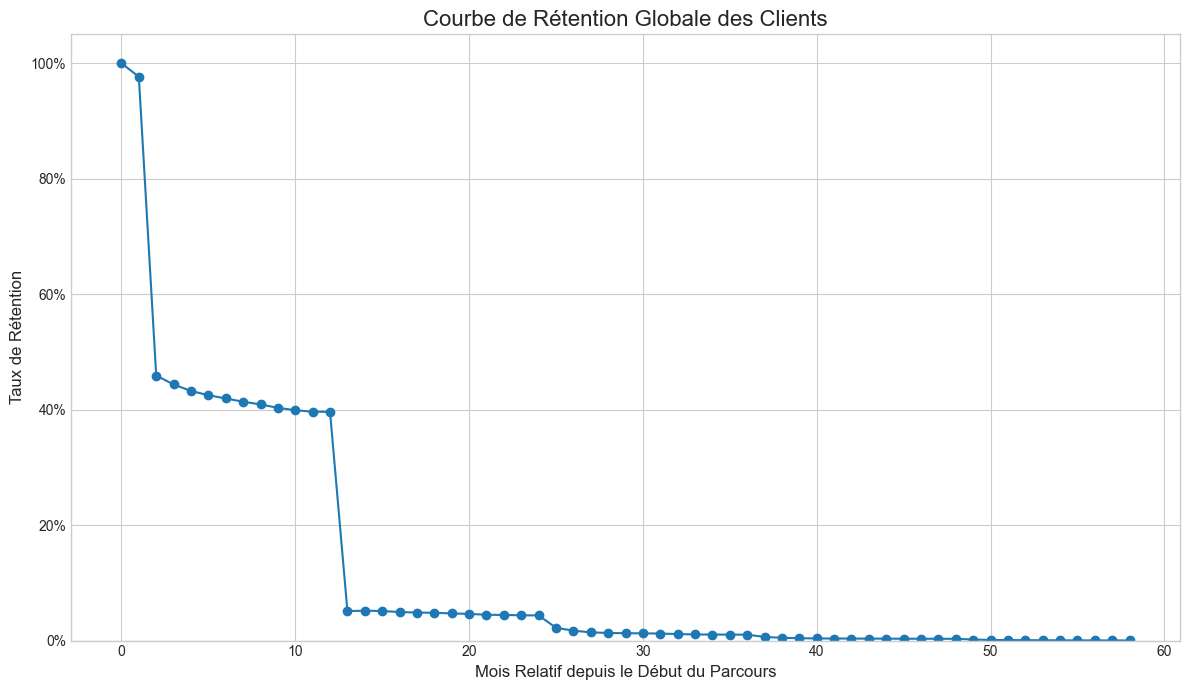


-> Calcul de la rétention segmentée par 'nom_offre'...


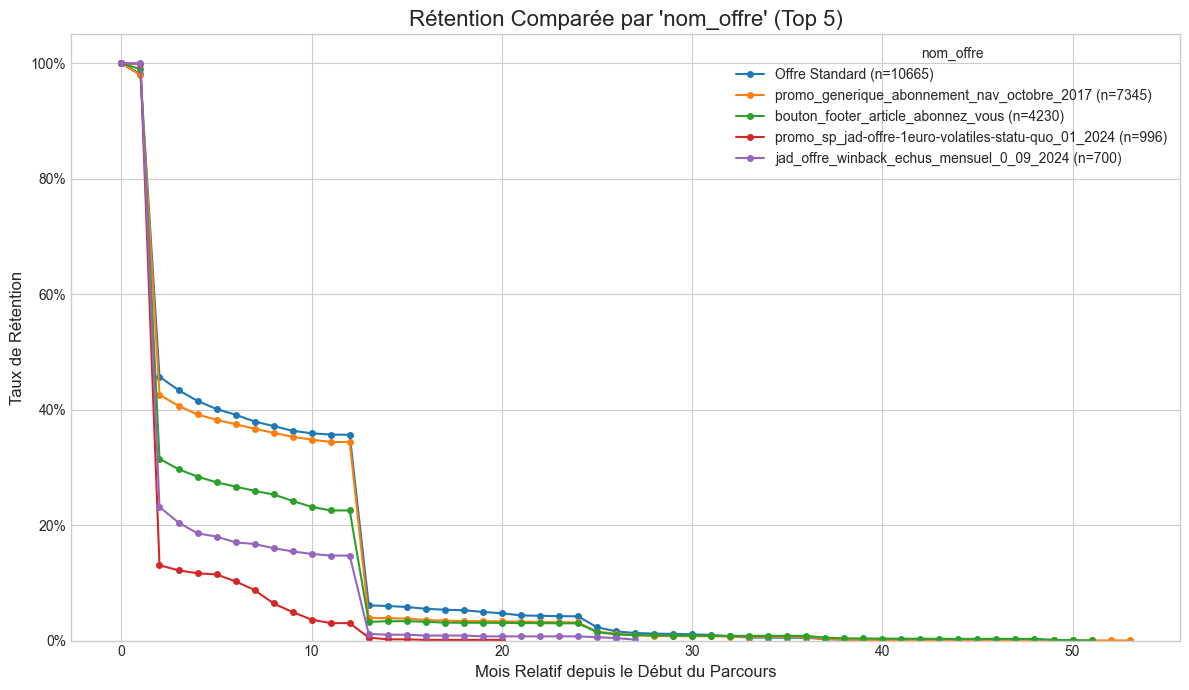


-> Calcul de la rétention segmentée par 'frequence'...


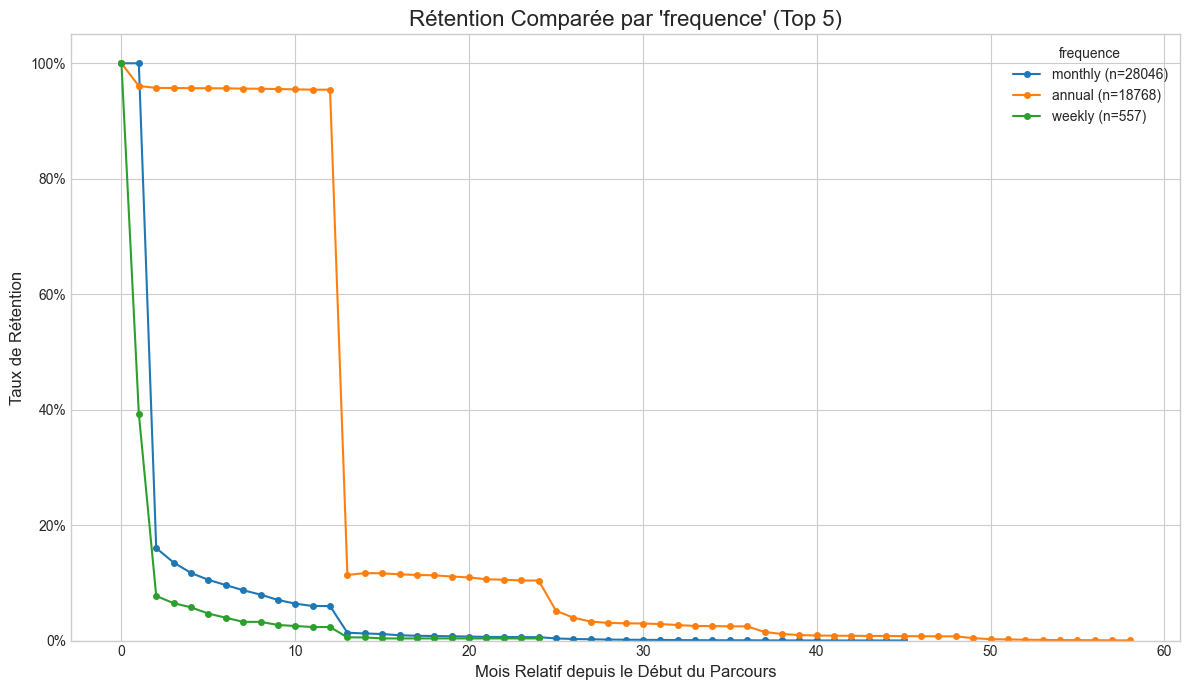


-> Calcul de la rétention segmentée par 'psp'...


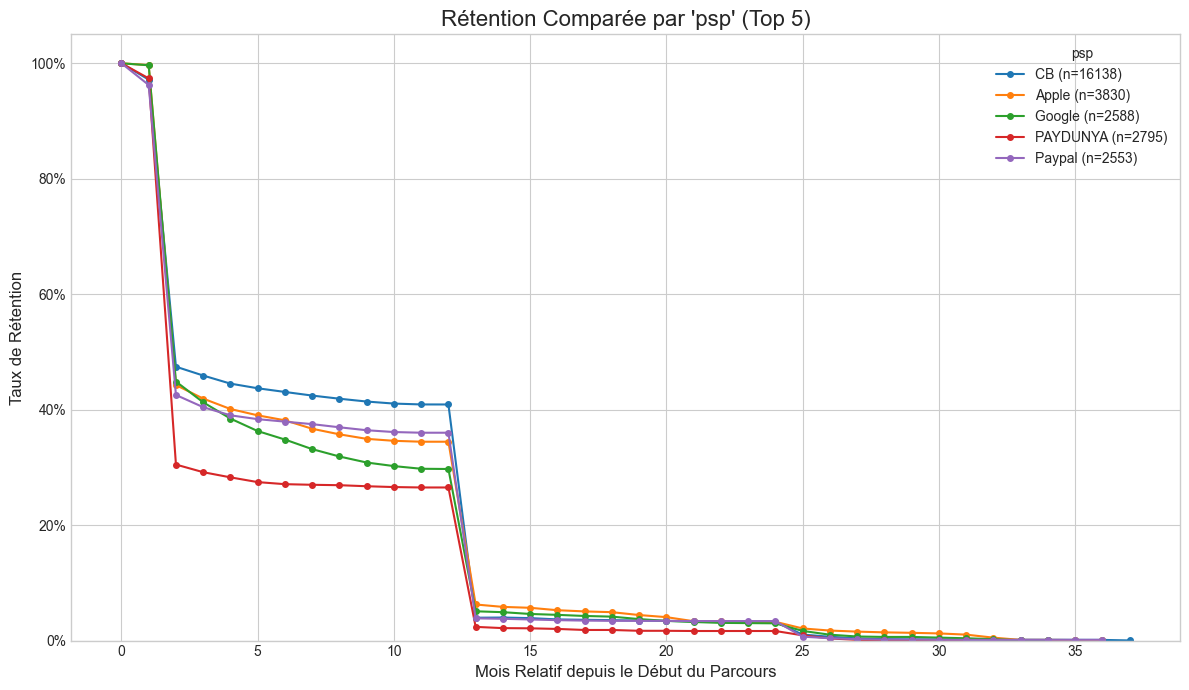


-> Calcul de la rétention segmentée par 'payment_origin'...


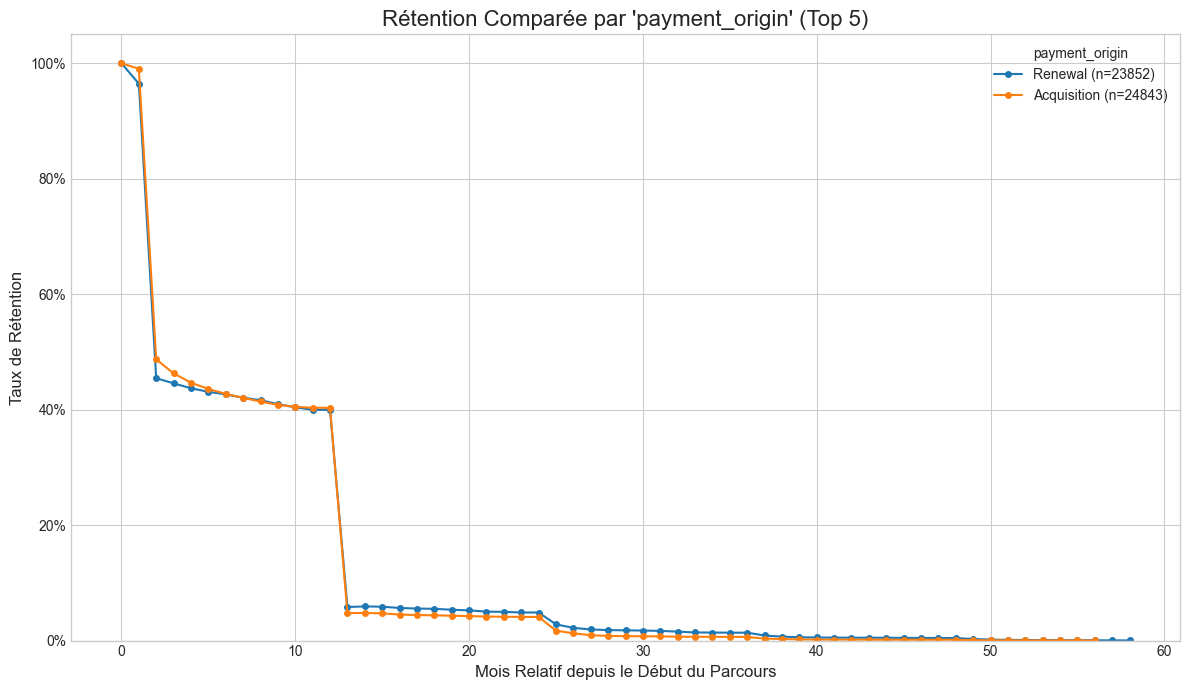


--- Sauvegarde du rapport final ---
-> Pipeline terminé. Fichier de sortie : 'rapport_mensuel_detaille.csv'


In [6]:
# -*- coding: utf-8 -*-
"""
Pipeline complet et final de traitement et d'analyse des données d'abonnements.
Version ultime avec analyse de rétention globale et segmentée.
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

# --- CONFIGURATION ---
TRANSACTIONS_FILE = 'transaction.csv'
COUPONS_FILE = 'Table des coupons-1.xlsx - Coupons.csv'
OUTPUT_FILE = 'rapport_mensuel_detaille.csv'

# --- Définition des fonctions ---

def load_and_merge_data(transactions_path, coupons_path):
    """Charge, fusionne, nettoie et enrichit les données initiales."""
    print("--- Étape 1: Chargement et fusion ---")
    try:
        df_trans = pd.read_csv(transactions_path, encoding='latin1')
        df_coupons = pd.read_csv(coupons_path, encoding='latin1')
        df_merged = pd.merge(df_trans, df_coupons, left_on='discount', right_on='Coupon Id', how='left')
        df_cleaned = df_merged.drop_duplicates().reset_index(drop=True)
        
        df_cleaned['nom_offre'] = np.where(pd.notna(df_cleaned['tm_campaign']), df_cleaned['tm_campaign'], df_cleaned['discount'])
        df_cleaned['nom_offre'] = df_cleaned['nom_offre'].fillna('Offre Standard')
        return df_cleaned
    except Exception as e:
        print(f"ERREUR CRITIQUE lors du chargement : {e}")
        return None

def group_and_repair_data(df):
    """Agrège les données et répare les dates manquantes."""
    if df is None: return None
    print("\n--- Étape 2: Agrégation et réparation des dates ---")
    
    agg_logic = {col: 'first' for col in df.columns if col != 'subscription_id'}
    agg_logic['order_date'] = 'first'
    agg_logic['ECHEANCE_date'] = 'last'
    for col in ['order_date (Année)', 'order_date (Mois)', 'order_date (Jour du mois)', 'ECHEANCE_annee', 'ECHEANCE_mois', 'ECHEANCE_jour']:
        agg_logic[col] = 'first'
    df_grouped = df.groupby('subscription_id').agg(agg_logic).reset_index()
    
    df_grouped['order_date_dt'] = pd.to_datetime(df_grouped['order_date'], errors='coerce')
    df_grouped['ECHEANCE_date_dt'] = pd.to_datetime(df_grouped['ECHEANCE_date'], errors='coerce')

    to_reconstruct_order = pd.isna(df_grouped['order_date_dt'])
    if to_reconstruct_order.any():
        date_cols = {'year': 'order_date (Année)', 'month': 'order_date (Mois)', 'day': 'order_date (Jour du mois)'}
        rename_dict = {v: k for k, v in date_cols.items()}
        df_rebuild = df_grouped.loc[to_reconstruct_order, list(date_cols.values())].rename(columns=rename_dict)
        df_grouped.loc[to_reconstruct_order, 'order_date_dt'] = pd.to_datetime(df_rebuild, errors='coerce')

    to_reconstruct_echeance = pd.isna(df_grouped['ECHEANCE_date_dt'])
    if to_reconstruct_echeance.any():
        date_cols = {'year': 'ECHEANCE_annee', 'month': 'ECHEANCE_mois', 'day': 'ECHEANCE_jour'}
        rename_dict = {v: k for k, v in date_cols.items()}
        df_rebuild = df_grouped.loc[to_reconstruct_echeance, list(date_cols.values())].rename(columns=rename_dict)
        df_grouped.loc[to_reconstruct_echeance, 'ECHEANCE_date_dt'] = pd.to_datetime(df_rebuild, errors='coerce')

    condition_fix_echeance = (df_grouped['frequence'].str.lower().str.contains('monthly', na=False) & pd.isna(df_grouped['ECHEANCE_date_dt']) & pd.notna(df_grouped['order_date_dt']))
    df_grouped.loc[condition_fix_echeance, 'ECHEANCE_date_dt'] = df_grouped.loc[condition_fix_echeance, 'order_date_dt'] + pd.Timedelta(days=30)
    
    df_grouped['order_date'] = df_grouped['order_date_dt']
    df_grouped['ECHEANCE_date'] = df_grouped['ECHEANCE_date_dt']
    
    df_grouped.dropna(subset=['order_date', 'ECHEANCE_date'], inplace=True)
    return df_grouped

def create_monthly_report(df_sub):
    """Transforme les abonnements en un rapport mensuel détaillé."""
    if df_sub is None: return None
    print("\n--- Étape 3: Création des parcours et expansion mensuelle ---")
    df_sorted = df_sub.sort_values(by=['customer_id', 'order_date']).copy()
    
    df_sorted['echeance_precedente'] = df_sorted.groupby('customer_id')['ECHEANCE_date'].shift(1)
    df_sorted['duree_trou_jours'] = (df_sorted['order_date'] - df_sorted['echeance_precedente']).dt.days
    seuil_churn_jours = np.where(df_sorted['frequence'].str.lower().str.contains('monthly', na=False), 35, 90)
    df_sorted['nouveau_parcours'] = np.where((df_sorted['duree_trou_jours'].isna()) | (df_sorted['duree_trou_jours'] >= seuil_churn_jours), True, False)
    
    df_sorted['id_parcours'] = df_sorted['customer_id'].astype(str) + '_' + df_sorted['nouveau_parcours'].cumsum().astype(str)
    df_sorted['journey_start_date'] = df_sorted.groupby('id_parcours')['order_date'].transform('min')
    
    all_months_data = []
    for row in df_sorted.itertuples(index=False):
        start_month = row.order_date.to_period('M').to_timestamp()
        end_month = row.ECHEANCE_date.to_period('M').to_timestamp()
        date_range = pd.date_range(start=start_month, end=end_month, freq='MS')
        for month_date in date_range:
            month_relatif = (month_date.year - row.journey_start_date.year) * 12 + (month_date.month - row.journey_start_date.month)
            new_row = {col: getattr(row, col) for col in row._fields}
            new_row.update({'month': month_date, 'month_relatif': month_relatif})
            all_months_data.append(new_row)
            
    return pd.DataFrame(all_months_data)

def analyze_retention(df):
    """Calcule et visualise la rétention globale et segmentée."""
    if df is None or df.empty: return
        
    print("\n--- Étape 4: Analyse de la Rétention ---")
    plt.style.use('seaborn-v0_8-whitegrid')

    # --- 4.1 Rétention Globale ---
    print("\n-> Calcul de la rétention globale...")
    initial_customers_global = df[df['month_relatif'] == 0]['customer_id'].nunique()
    if initial_customers_global > 0:
        retained_global = df.groupby('month_relatif')['customer_id'].nunique()
        retention_global_rate = (retained_global / initial_customers_global)
        
        fig, ax = plt.subplots(figsize=(12, 7))
        retention_global_rate.plot(kind='line', ax=ax, marker='o')
        ax.set_title("Courbe de Rétention Globale des Clients", fontsize=16)
        ax.set_xlabel("Mois Relatif depuis le Début du Parcours", fontsize=12)
        ax.set_ylabel("Taux de Rétention", fontsize=12)
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))
        ax.set_ylim(0)
        plt.tight_layout()
        plt.show()

    # --- 4.2 Rétention Segmentée ---
    # On se base sur les caractéristiques au début du parcours de chaque client
    df_initial_state = df[df['month_relatif'] == 0].drop_duplicates(subset=['id_parcours'])
    
    characteristics_to_segment = ['nom_offre', 'frequence', 'psp', 'payment_origin']
    for char in characteristics_to_segment:
        print(f"\n-> Calcul de la rétention segmentée par '{char}'...")
        
        # On prend les 5 catégories les plus fréquentes pour la lisibilité
        top_segments = df_initial_state[char].value_counts().nlargest(5).index
        
        fig, ax = plt.subplots(figsize=(12, 7))
        
        for segment in top_segments:
            # Identifier la cohorte pour ce segment
            cohort_ids = df_initial_state[df_initial_state[char] == segment]['customer_id'].unique()
            initial_count = len(cohort_ids)
            
            if initial_count == 0: continue
            
            # Filtrer le df principal pour ne garder que les clients de cette cohorte
            df_cohort = df[df['customer_id'].isin(cohort_ids)]
            
            # Calculer la rétention pour cette cohorte
            retained_count = df_cohort.groupby('month_relatif')['customer_id'].nunique()
            retention_rate = (retained_count / initial_count)
            
            # Tracer la courbe pour ce segment
            retention_rate.plot(kind='line', ax=ax, label=f"{segment} (n={initial_count})", marker='o', ms=4)

        ax.set_title(f"Rétention Comparée par '{char}' (Top 5)", fontsize=16)
        ax.set_xlabel("Mois Relatif depuis le Début du Parcours", fontsize=12)
        ax.set_ylabel("Taux de Rétention", fontsize=12)
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))
        ax.set_ylim(0)
        ax.legend(title=char)
        plt.tight_layout()
        plt.show()

def main():
    """Fonction principale qui orchestre l'ensemble du pipeline."""
    df_initial = load_and_merge_data(TRANSACTIONS_FILE, COUPONS_FILE)
    df_aggregated = group_and_repair_data(df_initial)
    df_monthly_report = create_monthly_report(df_aggregated)
    
    if df_monthly_report is not None:
        analyze_retention(df_monthly_report)
        
        print(f"\n--- Sauvegarde du rapport final ---")
        try:
            df_monthly_report.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')
            print(f"-> Pipeline terminé. Fichier de sortie : '{OUTPUT_FILE}'")
        except Exception as e:
            print(f"ERREUR CRITIQUE lors de la sauvegarde : {e}")

if __name__ == "__main__":
    main()

In [7]:
# -*- coding: utf-8 -*-
"""
Pipeline complet et final de traitement et d'analyse des données d'abonnements.
Version ultime avec une analyse ciblée sur le churn entre le mois 2 et le mois 3.
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
TRANSACTIONS_FILE = 'transaction.csv'
COUPONS_FILE = 'Table des coupons-1.xlsx - Coupons.csv'
OUTPUT_FILE = 'rapport_mensuel_detaille.csv'

# --- Définition des fonctions ---

def load_and_merge_data(transactions_path, coupons_path):
    """Charge, fusionne, nettoie et enrichit les données initiales."""
    print("--- Étape 1: Chargement et fusion ---")
    try:
        df_trans = pd.read_csv(transactions_path, encoding='latin1')
        df_coupons = pd.read_csv(coupons_path, encoding='latin1')
        df_merged = pd.merge(df_trans, df_coupons, left_on='discount', right_on='Coupon Id', how='left')
        df_cleaned = df_merged.drop_duplicates().reset_index(drop=True)
        
        df_cleaned['nom_offre'] = np.where(pd.notna(df_cleaned['tm_campaign']), df_cleaned['tm_campaign'], df_cleaned['discount'])
        df_cleaned['nom_offre'] = df_cleaned['nom_offre'].fillna('Offre Standard')
        return df_cleaned
    except Exception as e:
        print(f"ERREUR CRITIQUE lors du chargement : {e}")
        return None

def group_and_repair_data(df):
    """Agrège les données et répare les dates manquantes."""
    if df is None: return None
    print("\n--- Étape 2: Agrégation et réparation des dates ---")
    
    agg_logic = {col: 'first' for col in df.columns if col != 'subscription_id'}
    agg_logic['order_date'] = 'first'
    agg_logic['ECHEANCE_date'] = 'last'
    for col in ['order_date (Année)', 'order_date (Mois)', 'order_date (Jour du mois)', 'ECHEANCE_annee', 'ECHEANCE_mois', 'ECHEANCE_jour']:
        agg_logic[col] = 'first'
    df_grouped = df.groupby('subscription_id').agg(agg_logic).reset_index()
    
    df_grouped['order_date_dt'] = pd.to_datetime(df_grouped['order_date'], errors='coerce')
    df_grouped['ECHEANCE_date_dt'] = pd.to_datetime(df_grouped['ECHEANCE_date'], errors='coerce')

    to_reconstruct_order = pd.isna(df_grouped['order_date_dt'])
    if to_reconstruct_order.any():
        date_cols = {'year': 'order_date (Année)', 'month': 'order_date (Mois)', 'day': 'order_date (Jour du mois)'}
        rename_dict = {v: k for k, v in date_cols.items()}
        df_rebuild = df_grouped.loc[to_reconstruct_order, list(date_cols.values())].rename(columns=rename_dict)
        df_grouped.loc[to_reconstruct_order, 'order_date_dt'] = pd.to_datetime(df_rebuild, errors='coerce')

    to_reconstruct_echeance = pd.isna(df_grouped['ECHEANCE_date_dt'])
    if to_reconstruct_echeance.any():
        date_cols = {'year': 'ECHEANCE_annee', 'month': 'ECHEANCE_mois', 'day': 'ECHEANCE_jour'}
        rename_dict = {v: k for k, v in date_cols.items()}
        df_rebuild = df_grouped.loc[to_reconstruct_echeance, list(date_cols.values())].rename(columns=rename_dict)
        df_grouped.loc[to_reconstruct_echeance, 'ECHEANCE_date_dt'] = pd.to_datetime(df_rebuild, errors='coerce')

    condition_fix_echeance = (df_grouped['frequence'].str.lower().str.contains('monthly', na=False) & pd.isna(df_grouped['ECHEANCE_date_dt']) & pd.notna(df_grouped['order_date_dt']))
    df_grouped.loc[condition_fix_echeance, 'ECHEANCE_date_dt'] = df_grouped.loc[condition_fix_echeance, 'order_date_dt'] + pd.Timedelta(days=30)
    
    df_grouped['order_date'] = df_grouped['order_date_dt']
    df_grouped['ECHEANCE_date'] = df_grouped['ECHEANCE_date_dt']
    
    df_grouped.dropna(subset=['order_date', 'ECHEANCE_date'], inplace=True)
    return df_grouped

def create_monthly_report(df_sub):
    """Transforme les abonnements en un rapport mensuel détaillé."""
    if df_sub is None: return None
    print("\n--- Étape 3: Création des parcours et expansion mensuelle ---")
    df_sorted = df_sub.sort_values(by=['customer_id', 'order_date']).copy()
    
    df_sorted['echeance_precedente'] = df_sorted.groupby('customer_id')['ECHEANCE_date'].shift(1)
    df_sorted['duree_trou_jours'] = (df_sorted['order_date'] - df_sorted['echeance_precedente']).dt.days
    seuil_churn_jours = np.where(df_sorted['frequence'].str.lower().str.contains('monthly', na=False), 35, 90)
    df_sorted['nouveau_parcours'] = np.where((df_sorted['duree_trou_jours'].isna()) | (df_sorted['duree_trou_jours'] >= seuil_churn_jours), True, False)
    
    df_sorted['id_parcours'] = df_sorted['customer_id'].astype(str) + '_' + df_sorted['nouveau_parcours'].cumsum().astype(str)
    df_sorted['journey_start_date'] = df_sorted.groupby('id_parcours')['order_date'].transform('min')
    
    all_months_data = []
    for row in df_sorted.itertuples(index=False):
        start_month = row.order_date.to_period('M').to_timestamp()
        end_month = row.ECHEANCE_date.to_period('M').to_timestamp()
        date_range = pd.date_range(start=start_month, end=end_month, freq='MS')
        for month_date in date_range:
            month_relatif = (month_date.year - row.journey_start_date.year) * 12 + (month_date.month - row.journey_start_date.month)
            new_row = {col: getattr(row, col) for col in row._fields}
            new_row.update({'month': month_date, 'month_relatif': month_relatif})
            all_months_data.append(new_row)
            
    return pd.DataFrame(all_months_data)

def analyze_churn_at_month_2(df):
    """Analyse spécifiquement les clients qui partent entre le mois 2 et 3."""
    if df is None or df.empty: return
        
    print("\n" + "="*50)
    print("--- NOUVELLE ANALYSE : Zoom sur le churn entre le mois 2 et 3 ---")
    print("="*50)

    if 'duree_parcours' not in df.columns:
        df['duree_parcours'] = df.groupby('id_parcours')['month_relatif'].transform('max')

    # Isoler le groupe qui churne EXACTEMENT au mois 2
    df_churn_at_m2 = df[df['duree_parcours'] == 2].copy()
    
    # Isoler le groupe retenu (ceux qui durent plus longtemps)
    df_retained = df[df['duree_parcours'] > 2].copy()
    
    print(f"-> {df_churn_at_m2['customer_id'].nunique()} clients ont un parcours qui s'arrête exactement au mois 2.")
    print(f"-> Nous les comparons aux {df_retained['customer_id'].nunique()} clients qui restent au-delà de 3 mois.")

    if df_churn_at_m2.empty:
        print("Aucun client ne churne exactement au mois 2.")
        return

    # On ne s'intéresse qu'à l'état initial de chaque parcours (mois 0)
    churners_m2_initial = df_churn_at_m2[df_churn_at_m2['month_relatif'] == 0].drop_duplicates(subset=['id_parcours'])
    retained_initial = df_retained[df_retained['month_relatif'] == 0].drop_duplicates(subset=['id_parcours'])

    caracteristiques_a_analyser = ['nom_offre', 'frequence', 'payment_origin', 'psp']
    
    for char in caracteristiques_a_analyser:
        print(f"\n--- Comparaison pour : {char} (Churn M2 vs Retenus) ---")
        
        churn_dist = churners_m2_initial[char].value_counts(normalize=True).mul(100).rename('Churn M2 (%)')
        retained_dist = retained_initial[char].value_counts(normalize=True).mul(100).rename('Retenus > 3m (%)')
        
        df_dist = pd.concat([churn_dist, retained_dist], axis=1).fillna(0).sort_values(by='Churn M2 (%)', ascending=False)
        print(df_dist.head(10).round(2))


def main():
    """Fonction principale qui orchestre l'ensemble du pipeline."""
    df_initial = load_and_merge_data(TRANSACTIONS_FILE, COUPONS_FILE)
    df_aggregated = group_and_repair_data(df_initial)
    df_monthly_report = create_monthly_report(df_aggregated)
    
    if df_monthly_report is not None:
        # Lancer l'analyse ciblée sur le churn au mois 2
        analyze_churn_at_month_2(df_monthly_report)
        
        print(f"\n--- Sauvegarde du rapport final ---")
        try:
            df_monthly_report.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')
            print(f"-> Pipeline terminé. Fichier de sortie : '{OUTPUT_FILE}'")
        except Exception as e:
            print(f"ERREUR CRITIQUE lors de la sauvegarde : {e}")

if __name__ == "__main__":
    main()

--- Étape 1: Chargement et fusion ---

--- Étape 2: Agrégation et réparation des dates ---


/var/folders/sq/50hbq0292x93_z2jh1gmtt8m0000gn/T/ipykernel_39334/646486606.py:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_grouped['order_date_dt'] = pd.to_datetime(df_grouped['order_date'], errors='coerce')
/var/folders/sq/50hbq0292x93_z2jh1gmtt8m0000gn/T/ipykernel_39334/646486606.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_grouped['ECHEANCE_date_dt'] = pd.to_datetime(df_grouped['ECHEANCE_date'], errors='coerce')



--- Étape 3: Création des parcours et expansion mensuelle ---

--- NOUVELLE ANALYSE : Zoom sur le churn entre le mois 2 et 3 ---
-> 819 clients ont un parcours qui s'arrête exactement au mois 2.
-> Nous les comparons aux 20295 clients qui restent au-delà de 3 mois.

--- Comparaison pour : nom_offre (Churn M2 vs Retenus) ---
                                                  Churn M2 (%)  \
nom_offre                                                        
Offre Standard                                           29.60   
promo_generique_abonnement_nav_octobre_2017              16.13   
bouton_footer_article_abonnez_vous                        8.90   
country_medium_rfv_defaut_offre_1euro_avril_2024          2.17   
header                                                    2.17   
country_medium_rfv_low_offre_1euro_avril_2024             2.17   
country_low_rfv_defaut_offre_1euro_avril_2024             1.32   
jad_offre_winback_echus_mensuel_0_09_2024                 1.20   
country_mediu

In [8]:
# -*- coding: utf-8 -*-
"""
Pipeline complet et final, incluant une analyse de la "résurrection" des clients
considérés comme churnés.
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
TRANSACTIONS_FILE = 'transaction.csv'
COUPONS_FILE = 'Table des coupons-1.xlsx - Coupons.csv'
OUTPUT_FILE = 'rapport_mensuel_detaille.csv'

# --- Définition des fonctions ---

def load_and_merge_data(transactions_path, coupons_path):
    print("--- Étape 1: Chargement et fusion ---")
    try:
        df_trans = pd.read_csv(transactions_path, encoding='latin1')
        df_coupons = pd.read_csv(coupons_path, encoding='latin1')
        df_merged = pd.merge(df_trans, df_coupons, left_on='discount', right_on='Coupon Id', how='left')
        df_cleaned = df_merged.drop_duplicates().reset_index(drop=True)
        df_cleaned['nom_offre'] = np.where(pd.notna(df_cleaned['tm_campaign']), df_cleaned['tm_campaign'], df_cleaned['discount'])
        df_cleaned['nom_offre'] = df_cleaned['nom_offre'].fillna('Offre Standard')
        return df_cleaned
    except Exception as e:
        print(f"ERREUR CRITIQUE lors du chargement : {e}")
        return None

def group_and_repair_data(df):
    if df is None: return None
    print("\n--- Étape 2: Agrégation et réparation des dates ---")
    agg_logic = {col: 'first' for col in df.columns if col != 'subscription_id'}
    agg_logic.update({'order_date': 'first', 'ECHEANCE_date': 'last'})
    for col in ['order_date (Année)', 'order_date (Mois)', 'order_date (Jour du mois)', 'ECHEANCE_annee', 'ECHEANCE_mois', 'ECHEANCE_jour']:
        agg_logic[col] = 'first'
    df_grouped = df.groupby('subscription_id').agg(agg_logic).reset_index()
    
    df_grouped['order_date_dt'] = pd.to_datetime(df_grouped['order_date'], errors='coerce')
    df_grouped['ECHEANCE_date_dt'] = pd.to_datetime(df_grouped['ECHEANCE_date'], errors='coerce')

    # Reconstruction Phase
    to_reconstruct_order = pd.isna(df_grouped['order_date_dt'])
    if to_reconstruct_order.any():
        date_cols = {'year': 'order_date (Année)', 'month': 'order_date (Mois)', 'day': 'order_date (Jour du mois)'}
        rename_dict = {v: k for k, v in date_cols.items()}
        df_rebuild = df_grouped.loc[to_reconstruct_order, list(date_cols.values())].rename(columns=rename_dict)
        df_grouped.loc[to_reconstruct_order, 'order_date_dt'] = pd.to_datetime(df_rebuild, errors='coerce')

    to_reconstruct_echeance = pd.isna(df_grouped['ECHEANCE_date_dt'])
    if to_reconstruct_echeance.any():
        date_cols = {'year': 'ECHEANCE_annee', 'month': 'ECHEANCE_mois', 'day': 'ECHEANCE_jour'}
        rename_dict = {v: k for k, v in date_cols.items()}
        df_rebuild = df_grouped.loc[to_reconstruct_echeance, list(date_cols.values())].rename(columns=rename_dict)
        df_grouped.loc[to_reconstruct_echeance, 'ECHEANCE_date_dt'] = pd.to_datetime(df_rebuild, errors='coerce')

    # Imputation Phase
    condition_fix_echeance = (df_grouped['frequence'].str.lower().str.contains('monthly', na=False) & pd.isna(df_grouped['ECHEANCE_date_dt']) & pd.notna(df_grouped['order_date_dt']))
    df_grouped.loc[condition_fix_echeance, 'ECHEANCE_date_dt'] = df_grouped.loc[condition_fix_echeance, 'order_date_dt'] + pd.Timedelta(days=30)
    
    df_grouped['order_date'] = df_grouped['order_date_dt']
    df_grouped['ECHEANCE_date'] = df_grouped['ECHEANCE_date_dt']
    
    df_grouped.dropna(subset=['order_date', 'ECHEANCE_date'], inplace=True)
    return df_grouped

def create_monthly_report(df_sub):
    if df_sub is None: return None
    print("\n--- Étape 3: Création des parcours et expansion mensuelle ---")
    df_sorted = df_sub.sort_values(by=['customer_id', 'order_date']).copy()
    
    df_sorted['echeance_precedente'] = df_sorted.groupby('customer_id')['ECHEANCE_date'].shift(1)
    df_sorted['duree_trou_jours'] = (df_sorted['order_date'] - df_sorted['echeance_precedente']).dt.days
    seuil_churn_jours = np.where(df_sorted['frequence'].str.lower().str.contains('monthly', na=False), 35, 90)
    df_sorted['nouveau_parcours'] = np.where((df_sorted['duree_trou_jours'].isna()) | (df_sorted['duree_trou_jours'] >= seuil_churn_jours), True, False)
    
    df_sorted['id_parcours'] = df_sorted['customer_id'].astype(str) + '_' + df_sorted['nouveau_parcours'].cumsum().astype(str)
    df_sorted['journey_start_date'] = df_sorted.groupby('id_parcours')['order_date'].transform('min')
    
    all_months_data = []
    for row in df_sorted.itertuples(index=False):
        start_month = row.order_date.to_period('M').to_timestamp()
        end_month = row.ECHEANCE_date.to_period('M').to_timestamp()
        date_range = pd.date_range(start=start_month, end=end_month, freq='MS')
        for month_date in date_range:
            month_relatif = (month_date.year - row.journey_start_date.year) * 12 + (month_date.month - row.journey_start_date.month)
            new_row = {col: getattr(row, col) for col in row._fields}
            new_row.update({'month': month_date, 'month_relatif': month_relatif})
            all_months_data.append(new_row)
            
    return pd.DataFrame(all_months_data)

def analyze_resurrection(df):
    """Analyse les clients qui churnent tôt pour voir s'ils se réabonnent plus tard."""
    if df is None or df.empty: return
        
    print("\n" + "="*50)
    print("--- ANALYSE DE LA 'RÉSURRECTION' DES CLIENTS CHURNÉS ---")
    print("="*50)

    # Identifier la durée de chaque parcours
    if 'duree_parcours' not in df.columns:
        df['duree_parcours'] = df.groupby('id_parcours')['month_relatif'].transform('max')

    # Isoler les parcours qui s'arrêtent exactement au mois 2
    journeys_ending_at_m2 = df[df['duree_parcours'] == 2].drop_duplicates(subset=['id_parcours'])
    
    if journeys_ending_at_m2.empty:
        print("Aucun parcours ne s'arrête exactement au mois 2. Analyse de résurrection impossible.")
        return

    # Obtenir la liste des clients uniques de ces parcours
    churned_customer_ids = journeys_ending_at_m2['customer_id'].unique()
    print(f"-> {len(churned_customer_ids)} clients uniques ont un parcours qui s'arrête au mois 2.")

    # Pour chaque client, compter le nombre total de parcours distincts qu'il a eu
    total_journeys_per_customer = df[df['customer_id'].isin(churned_customer_ids)].groupby('customer_id')['id_parcours'].nunique()
    
    # Les clients "ressuscités" sont ceux qui ont plus d'un parcours
    resurrected_customer_ids = total_journeys_per_customer[total_journeys_per_customer > 1].index
    
    if len(resurrected_customer_ids) == 0:
        print("-> Aucun de ces clients ne s'est réabonné pour un nouveau parcours plus tard.")
        return

    resurrection_rate = len(resurrected_customer_ids) / len(churned_customer_ids) * 100
    print(f"-> {len(resurrected_customer_ids)} de ces clients ({resurrection_rate:.2f}%) ont 'ressuscité' en commençant un nouveau parcours plus tard.")
    
    # Calculer le temps avant la résurrection
    df_all_journeys = df.drop_duplicates(subset=['id_parcours']).sort_values(by=['customer_id', 'journey_start_date'])
    df_all_journeys['end_date_of_previous_journey'] = df_all_journeys.groupby('customer_id')['date_fin_abo'].shift(1)
    
    # On ne s'intéresse qu'aux parcours des clients ressuscités qui ne sont pas leur premier parcours
    df_resurrected_journeys = df_all_journeys[df_all_journeys['customer_id'].isin(resurrected_customer_ids)]
    df_resurrection_gaps = df_resurrected_journeys[df_resurrected_journeys['nouveau_parcours']].copy()
    
    df_resurrection_gaps['temps_avant_resurrection'] = (df_resurrection_gaps['journey_start_date'] - df_resurrection_gaps['end_date_of_previous_journey']).dt.days
    
    print("\nStatistiques sur le temps avant le nouveau réabonnement (en jours) :")
    print(df_resurrection_gaps['temps_avant_resurrection'].describe())

def main():
    """Fonction principale qui orchestre l'ensemble du pipeline."""
    df_initial = load_and_merge_data(TRANSACTIONS_FILE, COUPONS_FILE)
    df_aggregated = group_and_repair_data(df_initial)
    df_monthly_report = create_monthly_report(df_aggregated)
    
    if df_monthly_report is not None:
        # Renommer la colonne ici pour que la fonction d'analyse la trouve
        df_monthly_report = df_monthly_report.rename(columns={'ECHEANCE_date': 'date_fin_abo'})
        
        # Lancer l'analyse finale de "résurrection"
        analyze_resurrection(df_monthly_report)
        
        print(f"\n--- Sauvegarde du rapport final ---")
        try:
            df_monthly_report.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')
            print(f"-> Pipeline terminé. Fichier de sortie : '{OUTPUT_FILE}'")
        except Exception as e:
            print(f"ERREUR CRITIQUE lors de la sauvegarde : {e}")

if __name__ == "__main__":
    main()

--- Étape 1: Chargement et fusion ---

--- Étape 2: Agrégation et réparation des dates ---


/var/folders/sq/50hbq0292x93_z2jh1gmtt8m0000gn/T/ipykernel_39334/1914092485.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_grouped['order_date_dt'] = pd.to_datetime(df_grouped['order_date'], errors='coerce')
/var/folders/sq/50hbq0292x93_z2jh1gmtt8m0000gn/T/ipykernel_39334/1914092485.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_grouped['ECHEANCE_date_dt'] = pd.to_datetime(df_grouped['ECHEANCE_date'], errors='coerce')



--- Étape 3: Création des parcours et expansion mensuelle ---

--- ANALYSE DE LA 'RÉSURRECTION' DES CLIENTS CHURNÉS ---
-> 819 clients uniques ont un parcours qui s'arrête au mois 2.
-> 286 de ces clients (34.92%) ont 'ressuscité' en commençant un nouveau parcours plus tard.

Statistiques sur le temps avant le nouveau réabonnement (en jours) :
count     555.000000
mean      314.311712
std       266.307818
min      -155.000000
25%       125.000000
50%       207.000000
75%       437.500000
max      1307.000000
Name: temps_avant_resurrection, dtype: float64

--- Sauvegarde du rapport final ---
-> Pipeline terminé. Fichier de sortie : 'rapport_mensuel_detaille.csv'


In [9]:
# -*- coding: utf-8 -*-
"""
Analyse finale : Sur l'ensemble des clients qui partent tôt (dans les 3 mois),
combien reviennent, et après combien de temps ?
"""
import pandas as pd
import numpy as np

# --- CONFIGURATION ---
TRANSACTIONS_FILE = 'transaction.csv'
COUPONS_FILE = 'Table des coupons-1.xlsx - Coupons.csv'

# --- Définition des fonctions (regroupées pour la clarté) ---

def load_and_merge_data(transactions_path, coupons_path):
    print("--- Étape 1: Chargement et fusion ---")
    try:
        df_trans = pd.read_csv(transactions_path, encoding='latin1')
        df_coupons = pd.read_csv(coupons_path, encoding='latin1')
        df_merged = pd.merge(df_trans, df_coupons, left_on='discount', right_on='Coupon Id', how='left')
        df_cleaned = df_merged.drop_duplicates().reset_index(drop=True)
        return df_cleaned
    except Exception as e:
        print(f"ERREUR CRITIQUE lors du chargement : {e}")
        return None

def group_and_repair_data(df):
    if df is None: return None
    print("\n--- Étape 2: Agrégation et réparation des dates ---")
    agg_logic = {col: 'first' for col in df.columns if col != 'subscription_id'}
    agg_logic.update({'order_date': 'first', 'ECHEANCE_date': 'last'})
    for col in ['order_date (Année)', 'order_date (Mois)', 'order_date (Jour du mois)', 'ECHEANCE_annee', 'ECHEANCE_mois', 'ECHEANCE_jour']:
        agg_logic[col] = 'first'
    df_grouped = df.groupby('subscription_id').agg(agg_logic).reset_index()
    
    df_grouped['order_date_dt'] = pd.to_datetime(df_grouped['order_date'], errors='coerce')
    df_grouped['ECHEANCE_date_dt'] = pd.to_datetime(df_grouped['ECHEANCE_date'], errors='coerce')

    to_reconstruct_order = pd.isna(df_grouped['order_date_dt'])
    if to_reconstruct_order.any():
        date_cols = {'year': 'order_date (Année)', 'month': 'order_date (Mois)', 'day': 'order_date (Jour du mois)'}
        rename_dict = {v: k for k, v in date_cols.items()}
        df_rebuild = df_grouped.loc[to_reconstruct_order, list(date_cols.values())].rename(columns=rename_dict)
        df_grouped.loc[to_reconstruct_order, 'order_date_dt'] = pd.to_datetime(df_rebuild, errors='coerce')

    to_reconstruct_echeance = pd.isna(df_grouped['ECHEANCE_date_dt'])
    if to_reconstruct_echeance.any():
        date_cols = {'year': 'ECHEANCE_annee', 'month': 'ECHEANCE_mois', 'day': 'ECHEANCE_jour'}
        rename_dict = {v: k for k, v in date_cols.items()}
        df_rebuild = df_grouped.loc[to_reconstruct_echeance, list(date_cols.values())].rename(columns=rename_dict)
        df_grouped.loc[to_reconstruct_echeance, 'ECHEANCE_date_dt'] = pd.to_datetime(df_rebuild, errors='coerce')

    condition_fix_echeance = (df_grouped['frequence'].str.lower().str.contains('monthly', na=False) & pd.isna(df_grouped['ECHEANCE_date_dt']) & pd.notna(df_grouped['order_date_dt']))
    df_grouped.loc[condition_fix_echeance, 'ECHEANCE_date_dt'] = df_grouped.loc[condition_fix_echeance, 'order_date_dt'] + pd.Timedelta(days=30)
    
    df_grouped['order_date'] = df_grouped['order_date_dt']
    df_grouped['ECHEANCE_date'] = df_grouped['ECHEANCE_date_dt']
    
    df_grouped.dropna(subset=['order_date', 'ECHEANCE_date'], inplace=True)
    return df_grouped

def create_journey_data(df_sub):
    """Crée les parcours clients et retourne le DataFrame avec les colonnes de parcours."""
    if df_sub is None: return None
    print("\n--- Étape 3: Création des parcours clients ---")
    df_sorted = df_sub.sort_values(by=['customer_id', 'order_date']).copy()
    
    df_sorted['echeance_precedente'] = df_sorted.groupby('customer_id')['ECHEANCE_date'].shift(1)
    df_sorted['duree_trou_jours'] = (df_sorted['order_date'] - df_sorted['echeance_precedente']).dt.days
    seuil_churn_jours = np.where(df_sorted['frequence'].str.lower().str.contains('monthly', na=False), 35, 90)
    df_sorted['nouveau_parcours'] = np.where((df_sorted['duree_trou_jours'].isna()) | (df_sorted['duree_trou_jours'] >= seuil_churn_jours), True, False)
    
    df_sorted['id_parcours'] = df_sorted['customer_id'].astype(str) + '_' + df_sorted['nouveau_parcours'].cumsum().astype(str)
    df_sorted['journey_start_date'] = df_sorted.groupby('id_parcours')['order_date'].transform('min')
    
    # Calcul du mois relatif pour chaque abonnement (pas encore l'expansion mensuelle)
    df_sorted['start_month_relatif'] = ((df_sorted['order_date'].dt.year - df_sorted['journey_start_date'].dt.year) * 12 +
                                        (df_sorted['order_date'].dt.month - df_sorted['journey_start_date'].dt.month))
    df_sorted['end_month_relatif'] = ((df_sorted['ECHEANCE_date'].dt.year - df_sorted['journey_start_date'].dt.year) * 12 +
                                      (df_sorted['ECHEANCE_date'].dt.month - df_sorted['journey_start_date'].dt.month))
                                      
    df_sorted['duree_parcours'] = df_sorted.groupby('id_parcours')['end_month_relatif'].transform('max')
    
    return df_sorted

def analyze_resurrection_of_all_early_churners(df_journeys):
    """Analyse la 'résurrection' de tous les clients qui partent dans les 3 mois."""
    if df_journeys is None or df_journeys.empty: return
        
    print("\n" + "="*50)
    print("--- ANALYSE DE LA 'RÉSURRECTION' DE TOUS LES CHURNERS PRÉCOCES ---")
    print("="*50)

    # Identifier les parcours qui s'arrêtent dans les 3 premiers mois
    early_churn_journeys = df_journeys[df_journeys['duree_parcours'] <= 2].copy()
    
    # Obtenir la liste des clients uniques de ces parcours
    early_churn_customer_ids = early_churn_journeys['customer_id'].unique()
    print(f"-> {len(early_churn_customer_ids)} clients uniques ont au moins un parcours qui s'arrête dans les 3 mois.")

    # Pour chaque client, compter le nombre total de parcours distincts qu'il a eu
    total_journeys_per_customer = df_journeys[df_journeys['customer_id'].isin(early_churn_customer_ids)].groupby('customer_id')['id_parcours'].nunique()
    
    # Les clients "ressuscités" sont ceux qui ont plus d'un parcours
    resurrected_customer_ids = total_journeys_per_customer[total_journeys_per_customer > 1].index
    
    if len(resurrected_customer_ids) == 0:
        print("-> Aucun de ces clients ne s'est réabonné pour un nouveau parcours plus tard.")
        return

    resurrection_rate = len(resurrected_customer_ids) / len(early_churn_customer_ids) * 100
    print(f"-> {len(resurrected_customer_ids)} de ces clients ({resurrection_rate:.2f}%) ont 'ressuscité' en commençant un nouveau parcours plus tard.")
    
    # Calculer le temps avant la résurrection
    df_all_journeys = df_journeys.drop_duplicates(subset=['id_parcours']).sort_values(by=['customer_id', 'journey_start_date'])
    df_all_journeys['end_date_of_previous_journey'] = df_all_journeys.groupby('customer_id')['ECHEANCE_date'].shift(1)
    
    # On ne s'intéresse qu'aux parcours des clients ressuscités qui ne sont pas leur premier parcours
    df_resurrected_journeys = df_all_journeys[df_all_journeys['customer_id'].isin(resurrected_customer_ids)]
    df_resurrection_gaps = df_resurrected_journeys[df_resurrected_journeys['nouveau_parcours']].copy()
    
    df_resurrection_gaps['temps_avant_resurrection'] = (df_resurrection_gaps['order_date'] - df_resurrection_gaps['end_date_of_previous_journey']).dt.days
    
    print("\nStatistiques sur le temps avant le nouveau réabonnement (en jours) :")
    print(df_resurrection_gaps['temps_avant_resurrection'].describe())

def main():
    """Fonction principale qui orchestre l'ensemble du pipeline."""
    df_initial = load_and_merge_data(TRANSACTIONS_FILE, COUPONS_FILE)
    df_aggregated = group_and_repair_data(df_initial)
    df_journeys = create_journey_data(df_aggregated)
    
    if df_journeys is not None:
        analyze_resurrection_of_all_early_churners(df_journeys)

if __name__ == "__main__":
    main()

--- Étape 1: Chargement et fusion ---

--- Étape 2: Agrégation et réparation des dates ---


/var/folders/sq/50hbq0292x93_z2jh1gmtt8m0000gn/T/ipykernel_39334/654154742.py:36: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_grouped['order_date_dt'] = pd.to_datetime(df_grouped['order_date'], errors='coerce')
/var/folders/sq/50hbq0292x93_z2jh1gmtt8m0000gn/T/ipykernel_39334/654154742.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_grouped['ECHEANCE_date_dt'] = pd.to_datetime(df_grouped['ECHEANCE_date'], errors='coerce')



--- Étape 3: Création des parcours clients ---

--- ANALYSE DE LA 'RÉSURRECTION' DE TOUS LES CHURNERS PRÉCOCES ---
-> 28154 clients uniques ont au moins un parcours qui s'arrête dans les 3 mois.
-> 5224 de ces clients (18.56%) ont 'ressuscité' en commençant un nouveau parcours plus tard.

Statistiques sur le temps avant le nouveau réabonnement (en jours) :
count    7009.000000
mean      481.878442
std       342.349535
min      -155.000000
25%       199.000000
50%       391.000000
75%       703.000000
max      1542.000000
Name: temps_avant_resurrection, dtype: float64


In [10]:
# -*- coding: utf-8 -*-
"""
Pipeline complet et final de traitement et d'analyse des données d'abonnements.
Version ultime avec une analyse détaillée comparant les abonnés mensuels fidèles vs. les churners.
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
TRANSACTIONS_FILE = 'transaction.csv'
COUPONS_FILE = 'Table des coupons-1.xlsx - Coupons.csv'
OUTPUT_FILE = 'rapport_mensuel_detaille.csv'

# --- Définition des fonctions ---

def load_and_merge_data(transactions_path, coupons_path):
    print("--- Étape 1: Chargement et fusion ---")
    try:
        df_trans = pd.read_csv(transactions_path, encoding='latin1')
        df_coupons = pd.read_csv(coupons_path, encoding='latin1')
        df_merged = pd.merge(df_trans, df_coupons, left_on='discount', right_on='Coupon Id', how='left')
        df_cleaned = df_merged.drop_duplicates().reset_index(drop=True)
        df_cleaned['nom_offre'] = np.where(pd.notna(df_cleaned['tm_campaign']), df_cleaned['tm_campaign'], df_cleaned['discount'])
        df_cleaned['nom_offre'] = df_cleaned['nom_offre'].fillna('Offre Standard')
        return df_cleaned
    except Exception as e:
        print(f"ERREUR CRITIQUE lors du chargement : {e}")
        return None

def group_and_repair_data(df):
    if df is None: return None
    print("\n--- Étape 2: Agrégation et réparation des dates ---")
    agg_logic = {col: 'first' for col in df.columns if col != 'subscription_id'}
    agg_logic.update({'order_date': 'first', 'ECHEANCE_date': 'last'})
    for col in ['order_date (Année)', 'order_date (Mois)', 'order_date (Jour du mois)', 'ECHEANCE_annee', 'ECHEANCE_mois', 'ECHEANCE_jour']:
        agg_logic[col] = 'first'
    df_grouped = df.groupby('subscription_id').agg(agg_logic).reset_index()
    
    df_grouped['order_date_dt'] = pd.to_datetime(df_grouped['order_date'], errors='coerce')
    df_grouped['ECHEANCE_date_dt'] = pd.to_datetime(df_grouped['ECHEANCE_date'], errors='coerce')

    to_reconstruct_order = pd.isna(df_grouped['order_date_dt'])
    if to_reconstruct_order.any():
        date_cols = {'year': 'order_date (Année)', 'month': 'order_date (Mois)', 'day': 'order_date (Jour du mois)'}
        rename_dict = {v: k for k, v in date_cols.items()}
        df_rebuild = df_grouped.loc[to_reconstruct_order, list(date_cols.values())].rename(columns=rename_dict)
        df_grouped.loc[to_reconstruct_order, 'order_date_dt'] = pd.to_datetime(df_rebuild, errors='coerce')

    to_reconstruct_echeance = pd.isna(df_grouped['ECHEANCE_date_dt'])
    if to_reconstruct_echeance.any():
        date_cols = {'year': 'ECHEANCE_annee', 'month': 'ECHEANCE_mois', 'day': 'ECHEANCE_jour'}
        rename_dict = {v: k for k, v in date_cols.items()}
        df_rebuild = df_grouped.loc[to_reconstruct_echeance, list(date_cols.values())].rename(columns=rename_dict)
        df_grouped.loc[to_reconstruct_echeance, 'ECHEANCE_date_dt'] = pd.to_datetime(df_rebuild, errors='coerce')

    condition_fix_echeance = (df_grouped['frequence'].str.lower().str.contains('monthly', na=False) & pd.isna(df_grouped['ECHEANCE_date_dt']) & pd.notna(df_grouped['order_date_dt']))
    df_grouped.loc[condition_fix_echeance, 'ECHEANCE_date_dt'] = df_grouped.loc[condition_fix_echeance, 'order_date_dt'] + pd.Timedelta(days=30)
    
    df_grouped['order_date'] = df_grouped['order_date_dt']
    df_grouped['ECHEANCE_date'] = df_grouped['ECHEANCE_date_dt']
    
    df_grouped.dropna(subset=['order_date', 'ECHEANCE_date'], inplace=True)
    return df_grouped

def create_monthly_report(df_sub):
    if df_sub is None: return None
    print("\n--- Étape 3: Création des parcours et expansion mensuelle ---")
    df_sorted = df_sub.sort_values(by=['customer_id', 'order_date']).copy()
    
    df_sorted['echeance_precedente'] = df_sorted.groupby('customer_id')['ECHEANCE_date'].shift(1)
    df_sorted['duree_trou_jours'] = (df_sorted['order_date'] - df_sorted['echeance_precedente']).dt.days
    seuil_churn_jours = np.where(df_sorted['frequence'].str.lower().str.contains('monthly', na=False), 35, 90)
    df_sorted['nouveau_parcours'] = np.where((df_sorted['duree_trou_jours'].isna()) | (df_sorted['duree_trou_jours'] >= seuil_churn_jours), True, False)
    
    df_sorted['id_parcours'] = df_sorted['customer_id'].astype(str) + '_' + df_sorted['nouveau_parcours'].cumsum().astype(str)
    df_sorted['journey_start_date'] = df_sorted.groupby('id_parcours')['order_date'].transform('min')
    
    all_months_data = []
    for row in df_sorted.itertuples(index=False):
        start_month = row.order_date.to_period('M').to_timestamp()
        end_month = row.ECHEANCE_date.to_period('M').to_timestamp()
        date_range = pd.date_range(start=start_month, end=end_month, freq='MS')
        for month_date in date_range:
            month_relatif = (month_date.year - row.journey_start_date.year) * 12 + (month_date.month - row.journey_start_date.month)
            new_row = {col: getattr(row, col) for col in row._fields}
            new_row.update({'month': month_date, 'month_relatif': month_relatif})
            all_months_data.append(new_row)
            
    return pd.DataFrame(all_months_data)

def analyze_monthly_subscriber_profiles(df):
    """Analyse et compare les profils des abonnés mensuels qui restent vs. ceux qui partent."""
    if df is None or df.empty: return

    print("\n" + "="*50)
    print("--- ANALYSE DÉTAILLÉE : PROFILS DES ABONNÉS MENSUELS ---")
    print("="*50)

    # 1. Identifier la durée de chaque parcours
    df['duree_parcours'] = df.groupby('id_parcours')['month_relatif'].transform('max')

    # 2. Isoler les parcours qui ont commencé avec un abonnement mensuel
    df_initial_state = df[df['month_relatif'] == 0].drop_duplicates(subset=['id_parcours'])
    monthly_journeys_ids = df_initial_state[df_initial_state['frequence'].str.lower() == 'monthly']['id_parcours']
    
    if monthly_journeys_ids.empty:
        print("Aucun parcours mensuel à analyser.")
        return

    df_monthly_journeys = df[df['id_parcours'].isin(monthly_journeys_ids)].copy()
    print(f"Analyse sur {monthly_journeys_ids.nunique()} parcours mensuels.")

    # 3. Séparer en "Bons" et "Mauvais" abonnés mensuels
    good_monthly = df_monthly_journeys[df_monthly_journeys['duree_parcours'] > 2]
    bad_monthly = df_monthly_journeys[df_monthly_journeys['duree_parcours'] <= 2]

    good_monthly_initial = good_monthly[good_monthly['month_relatif'] == 0].drop_duplicates(subset=['id_parcours'])
    bad_monthly_initial = bad_monthly[bad_monthly['month_relatif'] == 0].drop_duplicates(subset=['id_parcours'])

    print(f"-> {bad_monthly_initial['customer_id'].nunique()} abonnés mensuels sont partis dans les 3 mois.")
    print(f"-> {good_monthly_initial['customer_id'].nunique()} abonnés mensuels sont restés plus de 3 mois.")
    
    # 4. Comparer leurs caractéristiques
    caracteristiques_a_analyser = ['nom_offre', 'payment_origin', 'psp', 'tm_source', 'tm_medium']

    for char in caracteristiques_a_analyser:
        print(f"\n--- Comparaison pour : {char} (Abonnés Mensuels) ---")
        
        bad_dist = bad_monthly_initial[char].value_counts(normalize=True).mul(100).rename('Churners Mensuels (%)')
        good_dist = good_monthly_initial[char].value_counts(normalize=True).mul(100).rename('Fidèles Mensuels (%)')
        
        df_dist = pd.concat([bad_dist, good_dist], axis=1).fillna(0).sort_values(by='Churners Mensuels (%)', ascending=False)
        print(df_dist.head(10).round(2))

def main():
    """Fonction principale qui orchestre l'ensemble du pipeline."""
    df_initial = load_and_merge_data(TRANSACTIONS_FILE, COUPONS_FILE)
    df_aggregated = group_and_repair_data(df_initial)
    df_monthly_report = create_monthly_report(df_aggregated)
    
    if df_monthly_report is not None:
        analyze_monthly_subscriber_profiles(df_monthly_report)
        
        print(f"\n--- Sauvegarde du rapport final ---")
        try:
            df_monthly_report.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')
            print(f"-> Pipeline terminé. Fichier de sortie : '{OUTPUT_FILE}'")
        except Exception as e:
            print(f"ERREUR CRITIQUE lors de la sauvegarde : {e}")

if __name__ == "__main__":
    main()

--- Étape 1: Chargement et fusion ---

--- Étape 2: Agrégation et réparation des dates ---


/var/folders/sq/50hbq0292x93_z2jh1gmtt8m0000gn/T/ipykernel_39334/681871874.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_grouped['order_date_dt'] = pd.to_datetime(df_grouped['order_date'], errors='coerce')
/var/folders/sq/50hbq0292x93_z2jh1gmtt8m0000gn/T/ipykernel_39334/681871874.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_grouped['ECHEANCE_date_dt'] = pd.to_datetime(df_grouped['ECHEANCE_date'], errors='coerce')



--- Étape 3: Création des parcours et expansion mensuelle ---

--- ANALYSE DÉTAILLÉE : PROFILS DES ABONNÉS MENSUELS ---
Analyse sur 33155 parcours mensuels.
-> 26323 abonnés mensuels sont partis dans les 3 mois.
-> 2486 abonnés mensuels sont restés plus de 3 mois.

--- Comparaison pour : nom_offre (Abonnés Mensuels) ---
                                                    Churners Mensuels (%)  \
nom_offre                                                                   
Offre Standard                                                      24.45   
promo_generique_abonnement_nav_octobre_2017                         14.75   
bouton_footer_article_abonnez_vous                                  10.20   
promo_sp_jad-offre-1euro-volatiles-statu-quo_01...                   2.94   
jad_offre_winback_echus_mensuel_0_09_2024                            2.25   
country_afemxof_rfv_defaut_mensuel_1e                                1.35   
country_medium_rfv_defaut_offre_1euro_avril_2024             